In [1]:
import jax.numpy as jnp
from matplotlib import pyplot as plt
from ang_pow import *
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX as CPJ

In [2]:
z = jnp.linspace(1e-4, 2.5, 100)
n_bins = 5
omega_b = 0.02242
omega_cdm = 0.11933
h = 0.6766
ns = 0.9665
ln_As = 3.047
cosmo_params = jnp.array([omega_b, omega_cdm, h, ns, ln_As])
c_min = 2.6
eta_0 = 0.7
m_bias = jnp.zeros(5)
galaxy_bias = jnp.ones(5)
ell = jnp.logspace(jnp.log10(100.0), jnp.log10(1000.0), num=20)
delta_z = jnp.zeros(5)
delta_z_lens, delta_z_source = delta_z, delta_z
fsky = 0.3
sigma_eps_sq = 0.26
n_eff = 30.
emulator = CPJ(probe='mpk_nonlin')

In [3]:
# build the n(z)
nz = compute_nz_bins(z, n_bins)


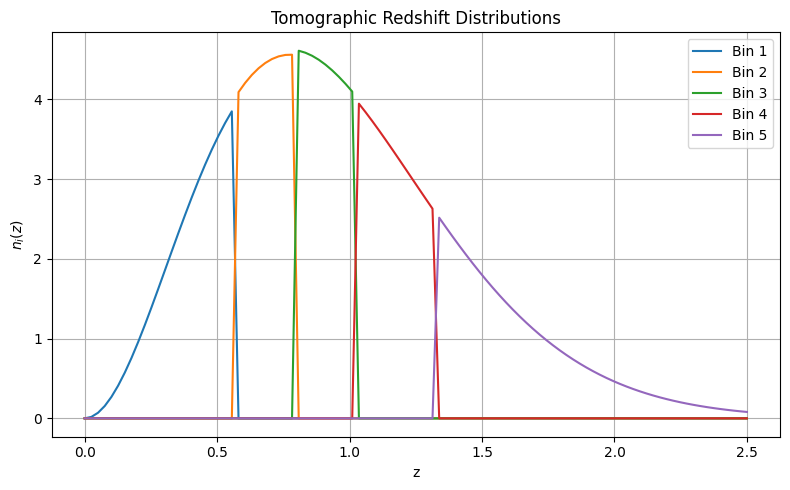

In [4]:
# plot the nz
# Compute tomographic n(z)
nz = compute_nz_bins(z, n_bins)

# Plot
plt.figure(figsize=(8, 5))
for i in range(n_bins):
    plt.plot(z, nz[i], label=f'Bin {i+1}')
plt.xlabel('z')
plt.ylabel(r'$n_i(z)$')
plt.title('Tomographic Redshift Distributions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
#compute the power spectra
k, p_k = compute_nonlinear_pk(z, cosmo_params, c_min, eta_0, emulator)

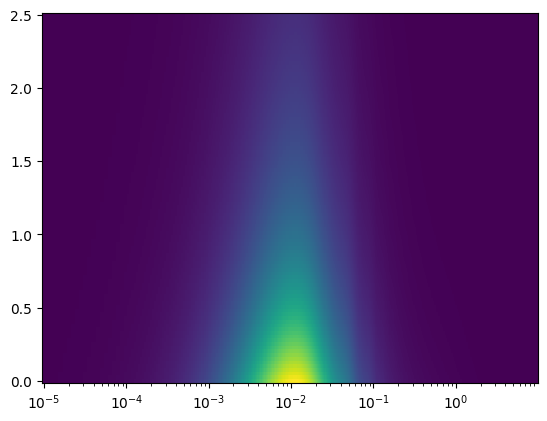

In [6]:
# plot the power spectra
plt.pcolormesh(k,z , p_k)
plt.xscale('log')
#plt.yscale('log')

In [7]:
cl_gg_all, cl_gk_all, cl_kk_all = compute_3x2pt_cls(nz, nz, z, k, p_k, ell,
                      delta_z_lens, delta_z_source, m_bias, galaxy_bias,
                      h, omega_b, omega_cdm)

W1 (99,) W2 (99,) P_ell (99,) w_z (99,)
W1 (99,) W2 (99,) P_ell (99,) w_z (99,)
W1 (99,) W2 (99,) P_ell (99,) w_z (99,)


In [8]:
d = flatten_cls_to_vector_jax_safe(cl_gg_all, cl_gk_all, cl_kk_all)

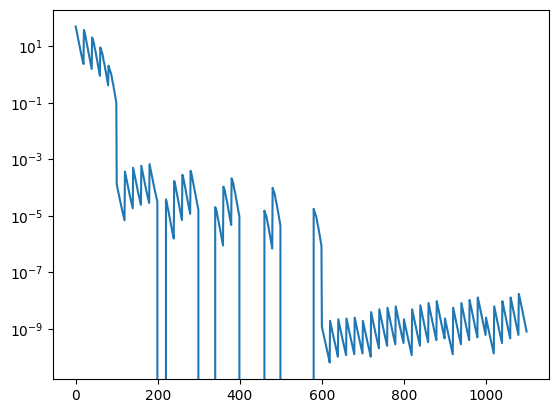

In [9]:
plt.plot(d)
plt.yscale('log')

In [ ]:
cov = compute_gaussian_covariance_binned(
    nz, nz, z, k, p_k, ell,
    delta_z, delta_z, m_bias, galaxy_bias,
    h, omega_b, omega_cdm,
    n_eff, sigma_eps_sq, fsky
)

In [ ]:
def plot_correlation_matrix(cov, title="Correlation Matrix"):
    # Compute correlation matrix
    diag = jnp.sqrt(jnp.diag(cov))
    corr = cov / jnp.outer(diag, diag)

    # Plot
    plt.figure(figsize=(8, 6))
    im = plt.imshow(corr, origin='lower', cmap='RdBu_r', vmin=-1, vmax=1)
    plt.colorbar(im, label='Correlation')
    plt.title(title)
    plt.xlabel('Data Vector Index')
    plt.ylabel('Data Vector Index')
    plt.tight_layout()
    plt.show()

plot_correlation_matrix(cov)